<div style='background-image: url("header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Salvus Mesher</div>
        <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Exercise 4: Yanns Checkerboard</div>
        </div>
    </div>
</div>

## Yanns Solid Fluid Checkerboard

In this notebook you build a 2D mesh with alternating solid and fluid blocks of elements.

The Checker and the Board:

![](checker.png)

In [1]:
# initialize notebook
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)

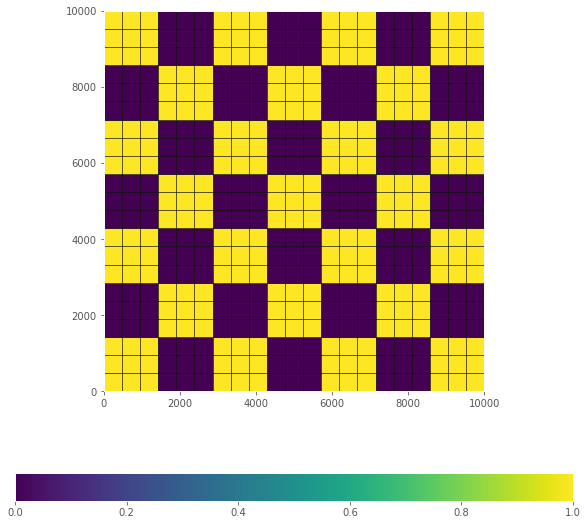

nelem = 441
dt    = 1.587302e-01


In [2]:
from pymesher.structured_grid_2D import StructuredGrid2D
from pymesher import Skeleton

# input in SI units
solid_vp = 1500.                # m/s
solid_vs = 1000.                # m/s
solid_rho = 1000.               # kg / m^3
fluid_vp = 1000.                # m/s
fluid_rho = 1200.               # kg / m^3
lx = 10000                      # domain size in x direction in m
ly = 10000                      # domain size in y direction in m
fmax = 1.                       # maximum frequency in Hz
block_size = 3                  # size of the solid and fluid blocks in
                                # number of elements

courant_number = 0.5
elements_per_wavelength = 2
# end input

# maximum element size
hmax = min(solid_vs, fluid_vp) / fmax / elements_per_wavelength

# compute number of elements
nelemx = int(lx / hmax) + 1
nelemy = int(ly / hmax) + 1

# generate rectilinear grid
sg = StructuredGrid2D.rectangle(nelemx, nelemy, max_x=lx, max_y=ly)

# create unstructured mesh
m = sg.get_unstructured_mesh()

# make fluid blocks
fluid = np.zeros((nelemx, nelemy), dtype='bool')
for i in range(block_size):
    for j in range(block_size):
        fluid[i::block_size * 2, j::block_size * 2] = True
        fluid[i+block_size::block_size * 2, j+block_size::block_size * 2] = \
            True

fluid = fluid.ravel()

# a mask for the solid elements
nfluid = np.logical_not(fluid)

# attach material properties
vpa = nfluid * solid_vp + fluid * fluid_vp
vsa = nfluid * solid_vs
rhoa = nfluid * solid_rho + fluid * fluid_rho

m.attach_field('fluid', fluid.astype('int'))
m.attach_field('VP', vpa)
m.attach_field('VS', vsa)
m.attach_field('RHO', rhoa)

# define outer boundaries
m.find_side_sets(mode='cartesian')

# compute time step
dt, dt_elem = m.compute_dt(vpa, courant_number)
m.attach_global_variable('dt', dt)
m.attach_field('dt', dt_elem)  # this is mainly for visualization

# There is some problem with the latest numpy and plotting boolean arrays.
# We thus convert it to an integer array. 1.0 is fluid, 0.0 not fluid.
m.plot(data=np.require(fluid, dtype=np.uint8))

# write to file
m.write_exodus('sf_checker.e')

print('================')
print('nelem = %d' % m.nelem)
print('dt    = %e' % dt)
print('================')